In [1]:
# Model Building
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Conv2DTranspose, Input, MaxPool2D, Softmax
from tensorflow.keras import models
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Dataset Loading
import tensorflow as tf
import tensorflow_datasets as tfds

# Plotting, Scoring
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

## Model Building

In [2]:
def BuildingBlock(x, filters, kernel_size, stride=1, padding='same'):
    if stride > 1:
        residual = Conv2D(filters, kernel_size=1, strides=stride)(x)
        residual = BatchNormalization()(residual)
    else:
        residual = x
    
    out = Conv2D(filters, kernel_size, strides=stride, padding=padding)(x)
    out = BatchNormalization()(out)
    out = ReLU()(out)
    out = Conv2D(filters, kernel_size, strides=1, padding=padding)(out)
    out = BatchNormalization()(out)

    out += residual
    out = ReLU()(out)
    return out

In [3]:
def EncoderBlock(x, filters, kernel_size, stride=1, padding='same'):
    x = BuildingBlock(x, filters, kernel_size, stride, padding)
    x = BuildingBlock(x, filters, kernel_size, stride=1, padding=padding)

    return x

In [4]:
def DecoderBlock(x, in_channels, filters, kernel_size, stride=1, padding='same', output_padding=(0, 0)):
    x = Conv2D(in_channels//4, kernel_size=1, strides=1, padding='valid')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2DTranspose(in_channels//4, kernel_size, strides=stride, padding=padding, output_padding=output_padding)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, kernel_size=1, strides=1, padding='valid')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    return x

In [5]:
def LinkNet():
    input = Input(shape=(128, 128, 3))

    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(input)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPool2D(pool_size=(3, 3), strides=2, padding='same')(x)

    e1 = EncoderBlock(x, filters=64, kernel_size=3, stride=1, padding='same')
    e2 = EncoderBlock(e1, filters=128, kernel_size=3, stride=2, padding='same')
    e3 = EncoderBlock(e2, filters=256, kernel_size=3, stride=2, padding='same')
    e4 = EncoderBlock(e3, filters=512, kernel_size=3, stride=2, padding='same')

    d4 = DecoderBlock(e4, in_channels=512, filters=256, kernel_size=3, stride=2, padding='same', output_padding=(1, 1)) + e3
    d3 = DecoderBlock(d4, in_channels=256, filters=128, kernel_size=3, stride=2, padding='same', output_padding=(1, 1)) + e2
    d2 = DecoderBlock(d3, in_channels=128, filters=64, kernel_size=3, stride=2, padding='same', output_padding=(1, 1)) + e1
    d1 = DecoderBlock(d2, in_channels=64, filters=64, kernel_size=3, stride=1, padding='same', output_padding=(0, 0)) + x

    y = Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', output_padding=(1, 1))(d1)
    y = BatchNormalization()(y)
    y = ReLU()(y)

    y = Conv2D(32, kernel_size=3, strides=1, padding='same')(y)
    y = BatchNormalization()(y)
    y = ReLU()(y)

    y = Conv2DTranspose(3, kernel_size=2, strides=2, padding='valid')(y)
    y = Softmax()(y)

    model = models.Model(inputs=[input], outputs=[y], name="LinkNet")
    model.compile(optimizer="adam", loss=SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
    print(model.summary())
    return model

In [6]:
model = LinkNet()

Model: "LinkNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Dataset Loading and Preprocessing

In [8]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete4CDY86/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete4CDY86/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [9]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [10]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [11]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [12]:
train_df = tfds.as_dataframe(train_images, info)
test_df = tfds.as_dataframe(test_images, info)

train_imgs = np.array([image for image in train_df['image']])
test_imgs = np.array([image for image in test_df['image']])

train_labels = np.array([label for label in train_df['label']])
test_labels = np.array([label for label in test_df['label']])

In [13]:
def pick_random_sample():
    index = np.random.randint(0, len(train_imgs))
    image = train_imgs[index]
    seg_mask = train_labels[index].reshape(128, 128)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(image)
    ax[1].imshow(seg_mask)

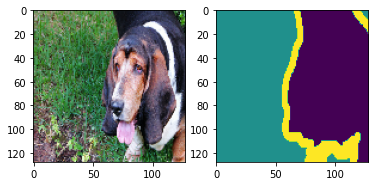

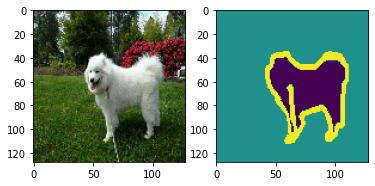

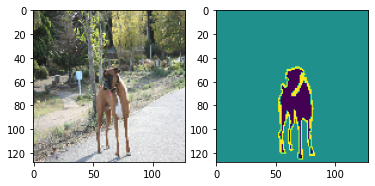

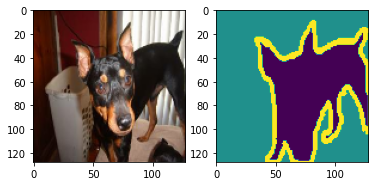

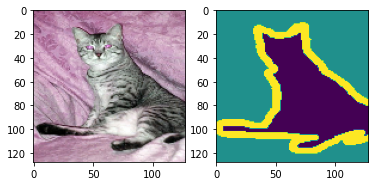

In [14]:
for _ in range(5):
    pick_random_sample()

## Training & Testing

In [15]:
BATCH_SIZE = 64
EPOCHS = 20

In [16]:
model_history = model.fit(train_imgs, train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.3)

Epoch 1/20
41/41 [==============================] - 20s 172ms/step - loss: 0.9587 - accuracy: 0.6471 - val_loss: 1.0654 - val_accuracy: 0.5997
Epoch 2/20
41/41 [==============================] - 5s 129ms/step - loss: 0.8142 - accuracy: 0.7742 - val_loss: 1.1220 - val_accuracy: 0.3228
Epoch 3/20
41/41 [==============================] - 5s 129ms/step - loss: 0.7705 - accuracy: 0.7877 - val_loss: 1.0792 - val_accuracy: 0.4368
Epoch 4/20
41/41 [==============================] - 5s 132ms/step - loss: 0.7503 - accuracy: 0.7992 - val_loss: 1.0444 - val_accuracy: 0.4883
Epoch 5/20
41/41 [==============================] - 5s 130ms/step - loss: 0.7390 - accuracy: 0.8068 - val_loss: 0.8895 - val_accuracy: 0.6552
Epoch 6/20
41/41 [==============================] - 5s 130ms/step - loss: 0.7309 - accuracy: 0.8138 - val_loss: 0.9703 - val_accuracy: 0.5681
Epoch 7/20
41/41 [==============================] - 6s 156ms/step - loss: 0.7256 - accuracy: 0.8218 - val_loss: 0.8554 - val_accuracy: 0.6897
Epoch

In [17]:
model.evaluate(test_imgs, test_labels)

115/115 [==============================] - 4s 27ms/step - loss: 0.6977 - accuracy: 0.8509


[0.6976755261421204, 0.8508510589599609]

## Performance Analysis

In [18]:
import plotly.express as px

px.line(pd.DataFrame(model_history.history), y=['loss', 'val_loss'])

In [19]:
px.line(pd.DataFrame(model_history.history), y=['accuracy', 'val_accuracy'])

## Sample Predictions

In [40]:
def predict_random_sample():
    index = np.random.randint(0, len(train_imgs))
    image = test_imgs[index]
    seg_mask = test_labels[index].reshape(128, 128)
    fig, ax = plt.subplots(1,3)
    pred = np.argmax(model.predict(np.array([image]), verbose=0).reshape(128, 128, 3), axis=2)
    fig.tight_layout(pad=0.2)
    ax[0].imshow(image)
    ax[1].imshow(seg_mask)
    ax[2].imshow(pred)

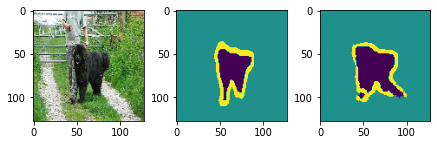

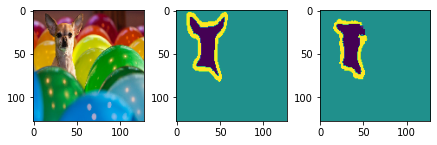

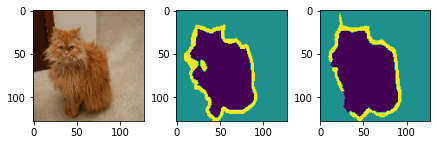

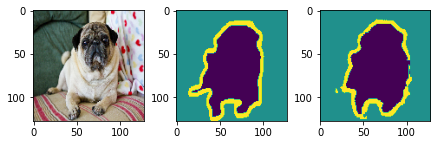

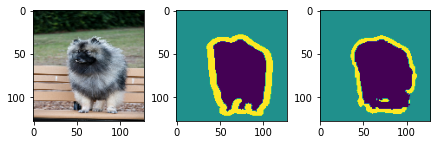

In [41]:
for _ in range(5):
    predict_random_sample()